# Generating synthetic contracts with signature areas

We want to generate synthetic contract pages with random text, randomly placed signature areas, and have these signature areas randomly contain/not contain a human-looking signature. The purpose is to build an app that will recognize signature areas in scanned text documents, and wheter or not these signature areas contain a human-looking signature.

We first write a small function that will random sample the high-level features of a page:

In [2]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from image_utils import ImageText
from faker import Faker
import pandas as pd
import json
import os
import random
import glob

In [3]:
def sample_high_level_features(text_number_of_areas_min=0, 
                               text_number_of_areas_max=10,
                               signature_number_of_areas_min=0, 
                               signature_number_of_areas_max=6,
                               ):
    
    text_number_of_areas = np.random.randint(low=text_number_of_areas_min,
                                             high=(text_number_of_areas_max+1))
    
    signature_number_of_areas = np.random.randint(low=signature_number_of_areas_min,
                                                  high=(signature_number_of_areas_max+1))

    return(text_number_of_areas, signature_number_of_areas)

Likewise we need a function to randomly sample the placement of a text/signature box. We include some logic to make sure all boxes are placed inside the page:

In [51]:
def sample_box_placement(width_min, width_max, height_min, height_max, page_width, page_height):
    
    height = np.random.randint(low=height_min, high=height_max)
    width = np.random.randint(low=width_min, high=width_max)
    if width<(height*1.2):
        width = np.int(height*1.2)
    
    x_max = page_width - width
    y_max = page_height - height
    
    x0 = np.random.randint(low=0, high=x_max)
    y0 = np.random.randint(low=0, high=y_max)
    
    x1 = x0 + width
    y1 = y0 + height
    
    return((x0,x1),(y0,y1))

We also need to keep track of previously added boxes and make sure new boxes don't overlap these. Later we'll decide what to do if a box overlaps.

In [52]:
def check_box_overlap(box_coordinates, existing_boxes_list):

    (x0,x1),(y0,y1) = box_coordinates
    
    for existing_box_coordinates in existing_boxes_list:
        
        (x0e,x1e),(y0e,y1e) = existing_box_coordinates
        
        horizontal_left_overlap  = ( (x0 <= x0e) and (x1 >= x0e) )
        horizontal_right_overlap = ( (x0 <= x1e) and (x1 >= x1e) )
        horizontal_inside_overlap= ( (x0 >= x0e) and (x1 <= x1e) )
        
        vertical_bottom_overlap  = ( (y0 <= y0e) and (y1 >= y0e) )
        vertical_top_overlap     = ( (y0 <= y1e) and (y1 >= y1e) )
        vertical_inside_overlap  = ( (y0 >= y0e) and (y1 <= y1e) )
        
        horizontal_overlap = (horizontal_left_overlap or horizontal_right_overlap or horizontal_inside_overlap)
        vertical_overlap = (vertical_bottom_overlap or vertical_top_overlap or vertical_inside_overlap)
        
        if (horizontal_overlap and vertical_overlap): 
            return(True)
        
    return(False)

This takes care of text/signature box generation and placement. But what about the contents of a box? Let's start with the text boxes:

In [53]:
def text_box_content(width, height, font_size, font = "DejaVuSerif.ttf", max_paragraph_num=100):
    
    fake = Faker()
    text = fake.paragraphs(max_paragraph_num)
    
    box_img = ImageText((width, height), background=(255, 255, 255, 200)) # 200 = alpha

    sentence_i = 0
    text_y_coord = 0
    while text_y_coord <= (height-font_size):
        box_img.write_text((0, text_y_coord), text[sentence_i], font_filename=font,
                           font_size=font_size, max_width=width, color="black")
        text_y_coord += font_size
        sentence_i += 1
    
    return(box_img)

We sample signatures from signature PNGs gahtered from Wikipedia:

In [54]:
def generate_signature(width, height, filename):
    
    img = Image.open(filename)
    new_width  = width
    new_height = height
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    return(img)

The signature boxes should contain the text "Som selger:" or "Som kjøper:" a horizontal line near the bottom, and (optionally) a signature above/overlapping the horizontal line:

In [55]:
def signature_box_content(width, height, text, signed=False, sig_directory="signatures", font="DejaVuSerif.ttf"):
    
    bottom_margin = np.int(np.max([np.round(height*0.15),1]))
    
    sig_img = Image.new("RGB", (width,height), color="white")
    
    draw = ImageDraw.Draw(sig_img)
    
    draw.line((0, sig_img.size[1]-bottom_margin, sig_img.size[0], sig_img.size[1]-bottom_margin), fill="black")
    
    fnt_size = bottom_margin
    txt_fnt = ImageFont.truetype(font, fnt_size)
    draw.text((0,0), text, font=txt_fnt, fill="black")
    
    if signed:
        
        sig_filename = random.choice(os.listdir(sig_directory))
        #print(sig_filename) Uncomment to debug signature.png-s with bad transparency masks
        signature = generate_signature(width, height-bottom_margin, sig_directory+"/"+sig_filename)
        sig_img.paste(signature, (0,bottom_margin), signature)
        
    return(sig_img, bottom_margin)

In [56]:
test_sig, _ = signature_box_content(300,100,"Som kjøper:",signed=True)

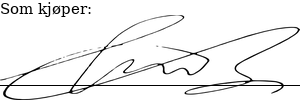

In [57]:
test_sig

We now have all the tools we need to generate some synthetic contract pages with randomly placed text boxes and signature fields. Let's put it all togehter!

In [58]:
def generate_contract_page(signed_probability=0.5,
                           page_width = 2480,
                           page_height= 3508,
                           text_number_of_areas_min=5, 
                           text_number_of_areas_max=20,
                           signature_number_of_areas_min=1, 
                           signature_number_of_areas_max=4,
                           text_width_min = 1000,
                           text_width_max = 2000,
                           text_height_min = 20,
                           text_height_max = 300,
                           signature_width_min = 200,
                           signature_width_max = 600,
                           signature_height_min= 100,
                           signature_height_max= 400,
                           font = "DejaVuSerif.ttf", # TODO: Randomly sample fonts from folder
                           font_size_min = 20,
                           font_size_max = 50
                           ):
    
    page_img = Image.new("RGB", (page_width, page_height), color="white")
    
    text_number_of_areas, signature_number_of_areas = sample_high_level_features(text_number_of_areas_min,
                                                                                 text_number_of_areas_max,
                                                                                 signature_number_of_areas_min,
                                                                                 signature_number_of_areas_max)
    existing_boxes_list = []

    text_box_i = 0
    while text_box_i < text_number_of_areas:
              
        overlap = True
        while overlap: # We keep resampling boxes until we find one that fits. TODO: Prevent infinite loop when there's no room for new boxes.
            box_coordinates = sample_box_placement(text_width_min, 
                                                   text_width_max, 
                                                   text_height_min, 
                                                   text_height_max,
                                                   page_width,
                                                   page_height)

            overlap = check_box_overlap(box_coordinates, existing_boxes_list)

        (x0,x1),(y0,y1) = box_coordinates

        box_width = x1-x0
        box_height = y1-y0
        
        font_size = np.random.randint(low=font_size_min, high=np.max([font_size_min+1,np.min([font_size_max,box_height])]))

        box_content = text_box_content(box_width, box_height, font_size, font)
        
        box_content.save("temp_box.png")
        box_content_png = Image.open("temp_box.png")
        
        page_img.paste(box_content_png,(x0,y0), box_content_png)

        existing_boxes_list.append(box_coordinates)

        text_box_i += 1

    signature_dict = {}
    signature_box_i = 0
    while signature_box_i < signature_number_of_areas:
        overlap = True
        while overlap: # We keep resampling boxes until we find one that fits. TODO: Prevent infinite loop when there's no room for new boxes.
            box_coordinates = sample_box_placement(signature_width_min, 
                                                   signature_width_max, 
                                                   signature_height_min, 
                                                   signature_height_max,
                                                   page_width,
                                                   page_height)
            
            overlap = check_box_overlap(box_coordinates, existing_boxes_list)
        
        (x0,x1),(y0,y1) = box_coordinates
        
        box_width = x1-x0
        box_height = y1-y0
        
        box_is_signed = np.random.rand()<signed_probability
        
        if np.random.rand()>0.5:
            sign_box_text = "Som kjøper:"
        else:
            sign_box_text = "Som selger:"
        
        box_content, bottom_margin = signature_box_content(box_width, box_height, sign_box_text, box_is_signed)
        
        box_content.save("temp_box.png")
        box_content_png = Image.open("temp_box.png")
        
        page_img.paste(box_content_png,(x0,y0))
        
        signature_dict.update({"signature"+str(signature_box_i) : {"x0" : x0, "x1" : x1, "y0" : y0, "y1" : y1, "signed" : box_is_signed}})
        
        existing_boxes_list.append(box_coordinates)
        signature_box_i += 1
        
    return(page_img, signature_dict)

Finally, let's write a function to generate and save N synthetic labeled contracts:

In [61]:
def generate_contracts(N,
                       path="output/",
                       signed_probability=0.5,
                       page_width = 2480,
                       page_height= 3508,
                       text_number_of_areas_min=5, 
                       text_number_of_areas_max=10,
                       signature_number_of_areas_min=1, 
                       signature_number_of_areas_max=4,
                       text_width_min = 1000,
                       text_width_max = 2000,
                       text_height_min = 20,
                       text_height_max = 300,
                       signature_width_min = 400,
                       signature_width_max = 600,
                       signature_height_min= 300,
                       signature_height_max= 500,
                       font = "DejaVuSerif.ttf",
                       font_size_min = 20,
                       font_size_max = 50
                       ):

    N_length = len(str(N))
    
    for n in range(0,N):
        
        page, page_dict = generate_contract_page(signed_probability,
                           page_width,
                           page_height,
                           text_number_of_areas_min, 
                           text_number_of_areas_max,
                           signature_number_of_areas_min, 
                           signature_number_of_areas_max,
                           text_width_min,
                           text_width_max,
                           text_height_min,
                           text_height_max,
                           signature_width_min,
                           signature_width_max,
                           signature_height_min,
                           signature_height_max,
                           font)
        
        n_string = str(n+1).zfill(N_length)
        
        #page = page.resize((1024, 1536), Image.ANTIALIAS)
        page.save(path+n_string+".png")
        
        with open(path+n_string+'.json', 'w') as fp:
            json.dump(page_dict, fp)
        
        # Write YOLOv2 labels
        # <object class> <x> <y> <width> <height>
        with open(path+n_string+'.txt', 'w') as fb:
            fb.write("")
        with open(path+n_string+'.txt', 'a') as fb:        
            for key in page_dict:
                x0 = page_dict[key]["x0"]
                x1 = page_dict[key]["x1"]
                y0 = page_dict[key]["y0"]
                y1 = page_dict[key]["y1"]
                signed = page_dict[key]["signed"]

                x_midpoint = ((x0+x1)/2) / page_width
                width = (x1-x0) / page_width

                if signed:
                    y_midpoint = ((y0+y1)/2) / page_height
                    height= (y1-y0) / page_height
                else:
                    bottom_margin = np.max([np.round((y1-y0)*0.15),1])
                    y_midpoint = (y1-bottom_margin) / page_height
                    height = bottom_margin / page_height

                

                fb.write( "\n"+str(np.int(signed)) + " " + 
                          str(x_midpoint) + " " +
                          str(y_midpoint) + " " +
                          str(width) + " " +
                          str(height))
        
        if n % 100 == 0:
            print(str(n+1) + " of " +str(N))
    
    # Current directory
    current_dir = 'output'
    # Percentage of images to be used for the test set
    percentage_test = 10;
    # Create and/or truncate train.txt and test.txt
    file_train = open('output/train.txt', 'w')  
    file_test = open('output/test.txt', 'w')
    # Populate train.txt and test.txt
    counter = 1  
    index_test = round(100 / percentage_test)  
    for pathAndFilename in glob.glob("output/*.png"):
        if counter == index_test:
                counter = + 1
                file_test.write(pathAndFilename + "\n")
        else:
            file_train.write(pathAndFilename + "\n")
            counter = counter + 1
        
    return("Done! Synthetic contracts written to "+path)

In [62]:
generate_contracts(10)

1 of 10


'Done! Synthetic contracts written to output/'

Sanity check of our annotation script:

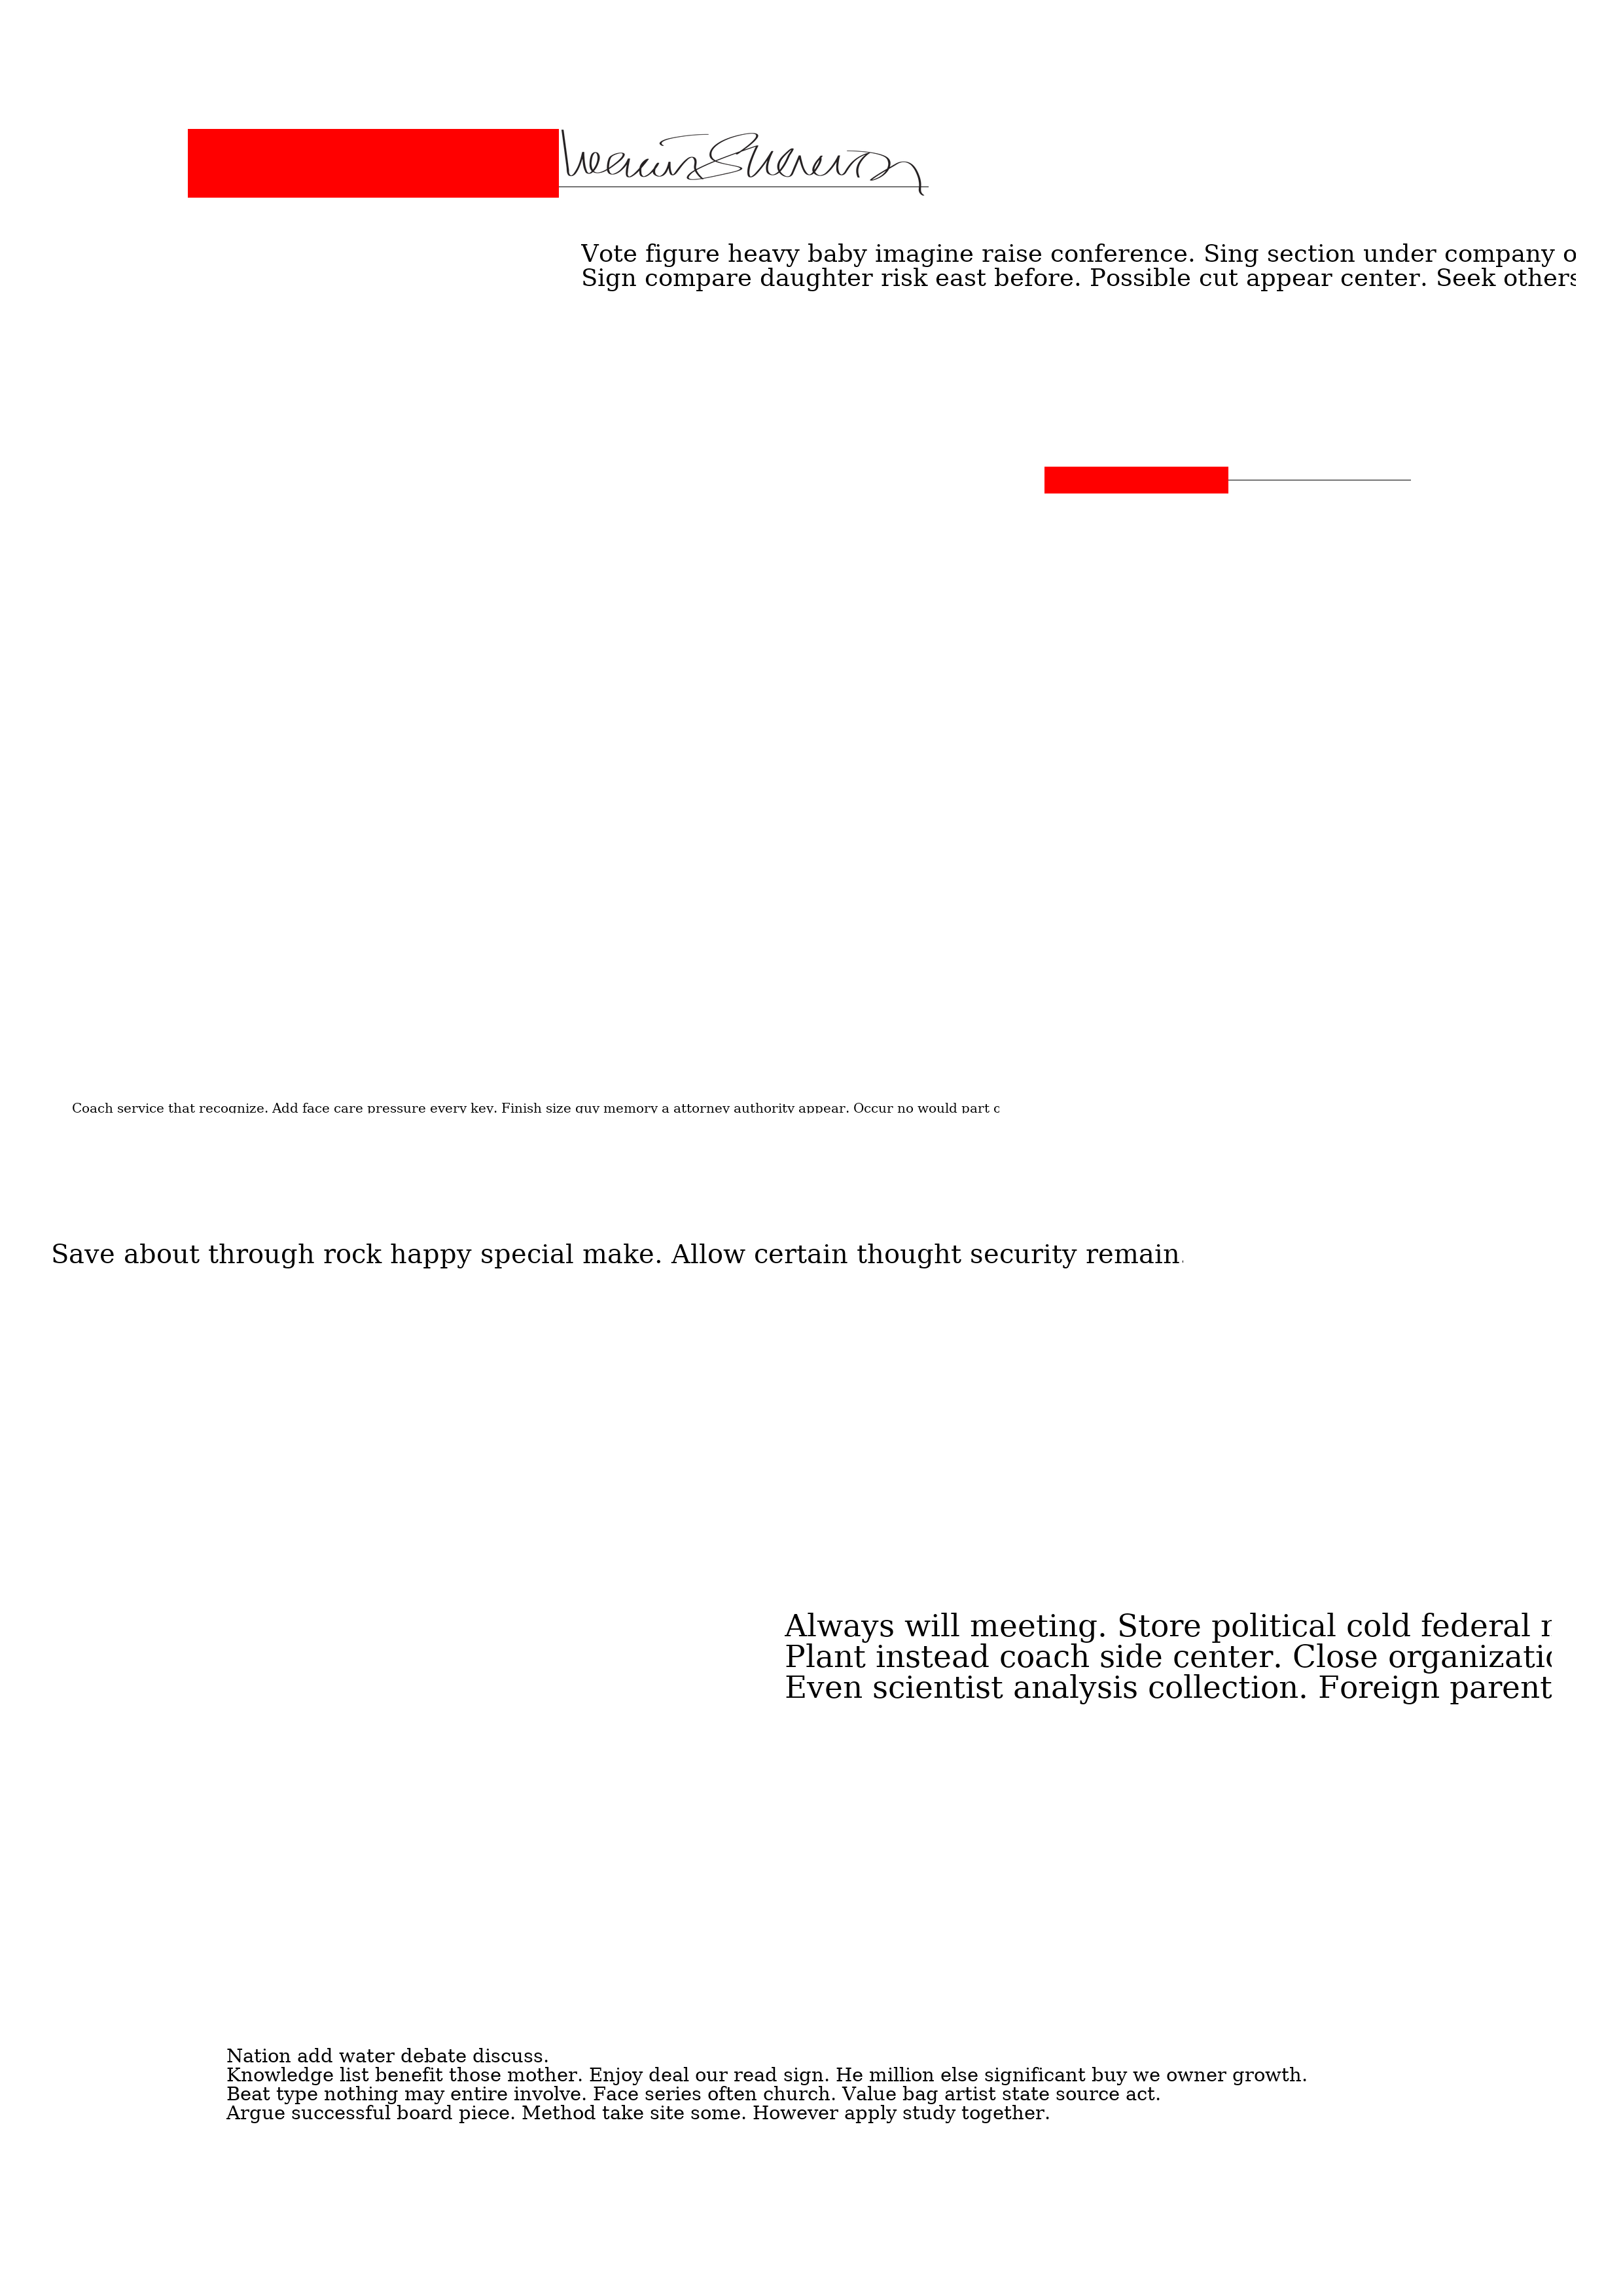

In [40]:
test_image = Image.open("output/0001.png")
img_width = test_image.size[0]
img_height = test_image.size[1]

draw = ImageDraw.Draw(test_image)

with open("output/0001.txt","r") as annotations:
    lines = annotations.read().split("\n")

for line in lines[1:]:
    params = line.split(" ")
    signed = np.int(params[0])
    x_mid = np.float(params[1])*img_width
    y_mid = np.float(params[2])*img_height
    width = np.float(params[3])*img_width
    height = np.float(params[4])*img_height
    
    x_left = np.int((x_mid-width/2))
    y_top  = np.int((y_mid-height/2))
    
    draw.rectangle(((x_left,y_top),(x_left+width,y_top+height)),fill="red")
    #draw.rectangle(((x_left,y_top),(x_left-width,y_top+height)),fill="red")
    
test_image